In [1]:
from sklearn.preprocessing import MinMaxScaler
#import geopandas
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pycountry
import seaborn as sns

In [2]:
mpl.rcParams['figure.facecolor'] = '.99'
mpl.rcParams['axes.facecolor'] = '.97'
mpl.rcParams['savefig.facecolor']
plt.rcParams['font.family'] = 'sans-serif'

### Load Dataset & Data Preprocessing

In [3]:
orig_data = pd.read_csv('world-happiness-report-2021.csv')
orig_data = orig_data[['Country name', 'Regional indicator', 'Ladder score',
       'Logged GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption']]

for col in orig_data.columns :
    if ' ' in col:
        orig_data.rename({col:col.replace(' ', '_')}, inplace=True, axis=1)
        
convert_list = {'Congo (Brazzaville)':'Congo', 'Czech Republic':'Czechia', 'Hong Kong S.A.R. of China':'Hong Kong',
                'Ivory Coast':"Côte d'Ivoire", 'Palestinian Territories':'Palestine, State of',
                'Swaziland':'Eswatini', 'Taiwan Province of China':'Taiwan'}

for (before, after) in convert_list.items():
    orig_data['Country_name'].loc[orig_data['Country_name'] == before] = after

c:\users\evfox\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
popu_data = pd.read_csv('population_by_country_2020.csv')
popu_data.rename(columns = {'Country (or dependency)':'Country_name', 
                       'Population (2020)':'Logged_Population', 
                            'Net Change': 'Net_Change',
                      'Density (P/Km²)':'Density', 
                        'Land Area (Km²)':'Logged_Land_Area',
                       'Migrants (net)':'Logged_Migrants', 
                        'Fert. Rate':'Fert_Rate',
                        'Med. Age':'Med_Age', 
                      'Urban Pop %':'Urban_Pop'}, 
                 inplace=True)

temp = popu_data[['Fert_Rate', 'Med_Age', 'Urban_Pop']].copy()
temp = temp.replace('N.A.', np.NaN)
temp['Urban_Pop'] = temp['Urban_Pop'].str[:-2]
popu_data[['Fert_Rate', 'Med_Age', 'Urban_Pop']] = temp.astype('float64')
popu_data['Urban_Pop'] = popu_data['Urban_Pop']/100

convert_list2 = {'Czech Republic (Czechia)':'Czechia', 'State of Palestine':'Palestine, State of'}

for (before, after) in convert_list2.items():
    popu_data['Country_name'].loc[popu_data['Country_name'] == before] = after
    
def log(n):
    if n < 0:
        return -(np.log(-n))
    elif n > 0:
        return np.log(n)
    else:
        return n

for item in ('Logged_Population', 'Logged_Land_Area', 'Logged_Migrants'):
    popu_data.loc[:, item] = popu_data[item].map(lambda x: log(x))
    
merged_data = orig_data.merge(popu_data, how='left')

In [5]:
ts_data = pd.read_csv('world-happiness-report.csv')
ts_data = ts_data[['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption']]

ts_data.rename(columns = {'Life Ladder':'Ladder_score', 
                          'Log GDP per capita':'Logged_GDP_per_capita', 
                          'Healthy life expectancy at birth':'Healthy_life_expectancy'},
               inplace=True)

for col in ts_data.columns:
    if ' ' in col:
        ts_data.rename({col:col.replace(' ', '_')}, inplace=True, axis=1)

for before, after in convert_list.items():
    ts_data['Country_name'].loc[ts_data['Country_name'] == before] = after

ts_data = ts_data.merge(orig_data[['Country_name', 'Regional_indicator']], how='left')
    
region_add = {'Latin America and Caribbean':['Belize', 'Cuba', 'Guyana', 'Suriname', 
                                             'Trinidad and Tobago'],
              'Middle East and North Africa':['Oman', 'Qatar', 'Syria'], 
              'South Asia':['Bhutan'], 
              'Sub-Saharan Africa':['Angola', 'Central African Republic', 'Congo (Kinshasa)', 
                                    'Djibouti', 'Somalia', 'Somaliland region', 'South Sudan',
                                   'Sudan',]
             } 
              
for region in region_add.keys():
    ts_data['Regional_indicator'].loc[ts_data['Country_name'].isin(region_add[region])] = region

### Exploratory Data Analysis

In [7]:
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

alpha3 = pd.concat([orig_data['Country_name'], orig_data['Ladder_score'], 
                    pd.DataFrame(alpha3code(orig_data['Country_name']), columns=['code'])], axis=1)

code_list = {'Taiwan':'TWN', 'South Korea':'KOR', 'Moldova':'MDA', 'Bolivia':'BOL', 'Russia':'RUS', 
                 'Vietnam':'VNM', 'Laos':'LAO', 'Venezuela':'VEN', 'Iran':'IRN', 'Tanzania':'TZA'}

for country, code in code_list.items():
    alpha3['code'].loc[alpha3['Country_name'] == country] = code

c:\users\evfox\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
#world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#world.columns=['pop_est', 'continent', 'name', 'code', 'gdp_md_est', 'geometry']

#merge=pd.merge(world,alpha3,on='code')

#merge

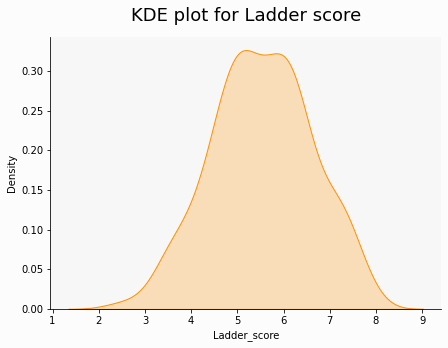

In [9]:
fig = plt.figure(figsize=(7, 5))
ax = sns.kdeplot(x='Ladder_score', color='#FF9001', fill=True, data=orig_data)
ax.set_title('KDE plot for Ladder score', fontdict={'fontsize':18}, pad=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

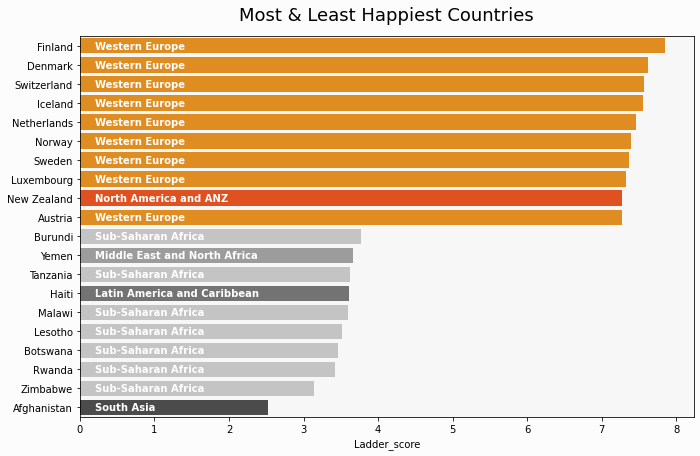

In [10]:
top_bottom_10 = pd.concat([orig_data[:10], orig_data[-10:]])[['Country_name', 'Regional_indicator', 'Ladder_score']] 

top_bottom_regions = top_bottom_10['Regional_indicator'].reset_index(drop=True)
region_color1 = dict(zip(top_bottom_regions.unique(), color_list_1))
region_palette1 = list(top_bottom_regions.map(lambda x: region_color1[x]))

fig = plt.figure(figsize=(11, 7))
ax = sns.barplot(x='Ladder_score', y='Country_name', palette=region_palette1, orient='h', data=top_bottom_10)

for i in range(len(regions)):
    ax.annotate(regions[i], xy=(0.2, i+0.15), weight='bold', color='#FFFFFF')

ax.set_title('Most & Least Happiest Countries', fontdict={'fontsize':18}, pad=16)
ax.set_ylabel('');

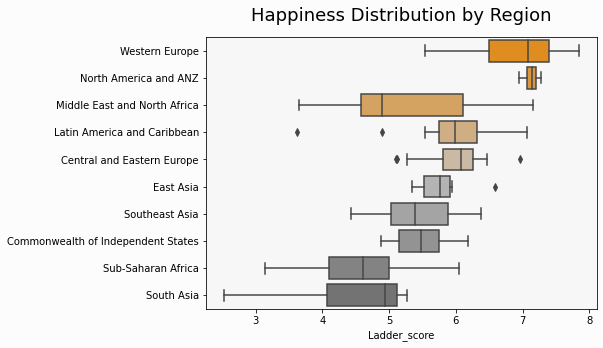

In [127]:
category_palette = ['#FF9001','#F39A28','#E7A54F','#DCAF76','#D0BA9D',
               '#B4B4B4','#A4A4A4','#939393','#838383','#737373']

fig = plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Ladder_score', y='Regional_indicator', palette=category_palette, data=orig_data)
ax.set_title('Happiness Distribution by Region', fontdict={'fontsize':18}, pad=16)
ax.set_ylabel('');

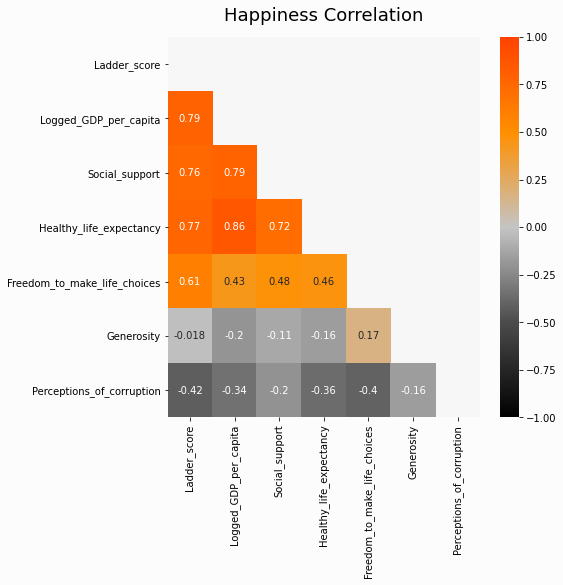

In [12]:
norm = mpl.colors.Normalize(-1,1)
colors = [[norm(-1.0), '#000000'],
          [norm(-0.5), '#4B4B4B'],
          [norm(0), '#C4C4C4'],
          [norm(0.5), '#FF9001'],
          [norm(1.0), '#FF4200']]
heat_cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

fig = plt.figure(figsize=(7,7))
mask = np.triu(np.ones_like(orig_data.corr(), dtype=np.bool))
ax = sns.heatmap(orig_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=heat_cmap)
ax.set_title('Happiness Correlation', fontdict={'fontsize':18}, pad=16);

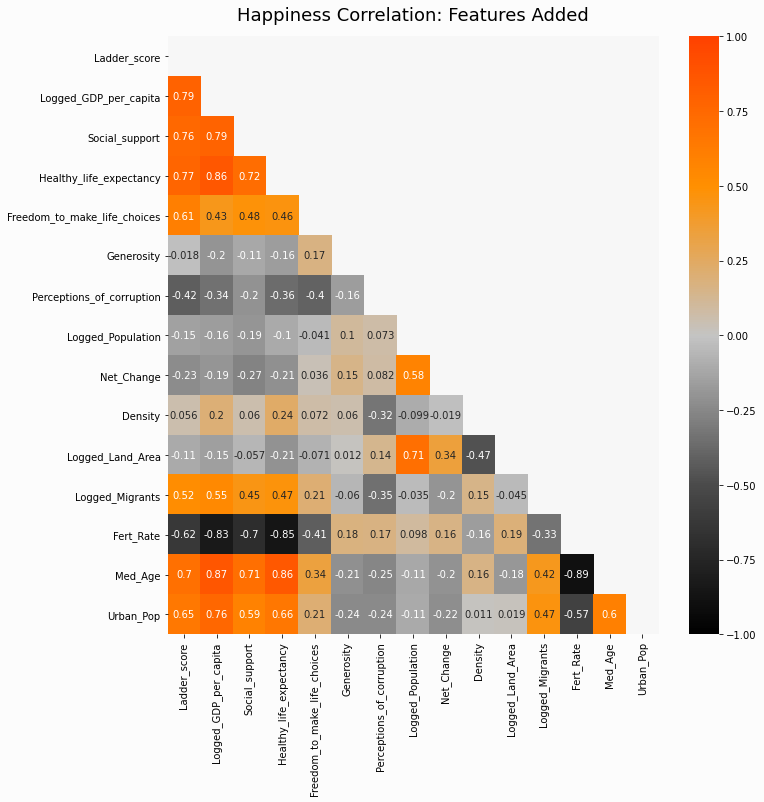

In [13]:
fig = plt.figure(figsize=(11,11))
mask = np.triu(np.ones_like(merged_data.corr(), dtype=np.bool))
ax = sns.heatmap(merged_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=heat_cmap)
ax.set_title('Happiness Correlation: Features Added', fontdict={'fontsize':18}, pad=16);

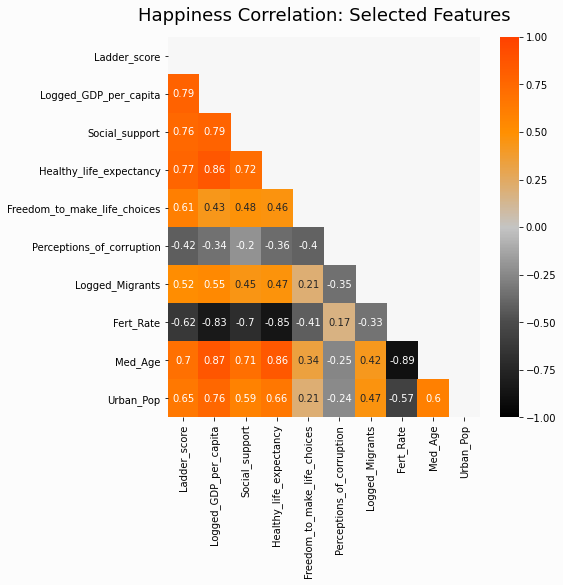

In [14]:
selected_data = merged_data.drop(['Generosity', 'Logged_Population', 'Net_Change', 'Density', 'Logged_Land_Area'], axis=1)

fig = plt.figure(figsize=(7,7))
mask = np.triu(np.ones_like(selected_data.corr(), dtype=np.bool))
ax = sns.heatmap(selected_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=heat_cmap)
ax.set_title('Happiness Correlation: Selected Features', fontdict={'fontsize':18}, pad=16);

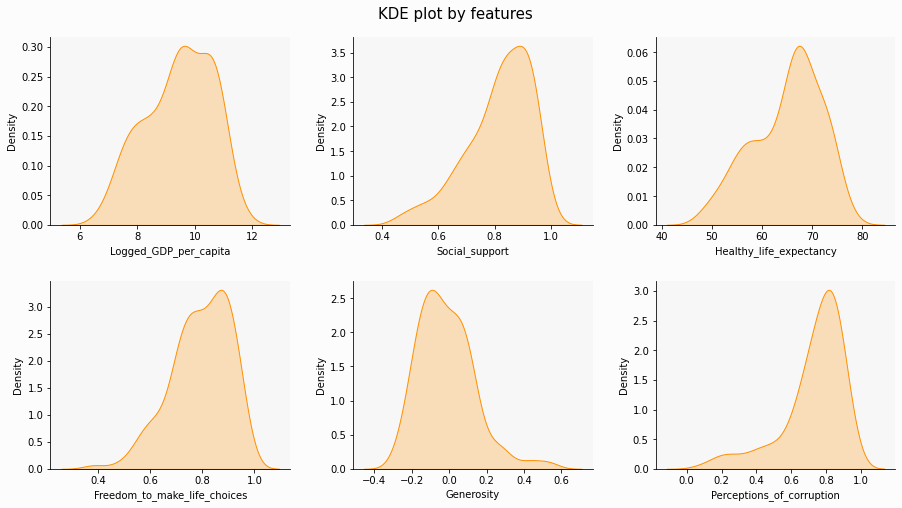

In [15]:
score_and_features = orig_data.columns.drop(['Country_name', 'Regional_indicator'])
features = orig_data.columns.drop(['Country_name', 'Regional_indicator', 'Ladder_score'])

fig, axes = plt.subplots(2,3, figsize=(13,7))

for idx, col in enumerate(orig_features):
    fig.tight_layout(pad=2)
    ax = axes[idx//3][idx%3] 
    sns.kdeplot(x=col, color='#FF9001', fill=True, ax=ax, data=orig_data)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.suptitle(f'KDE plot by features', fontsize=15, y=1.02);

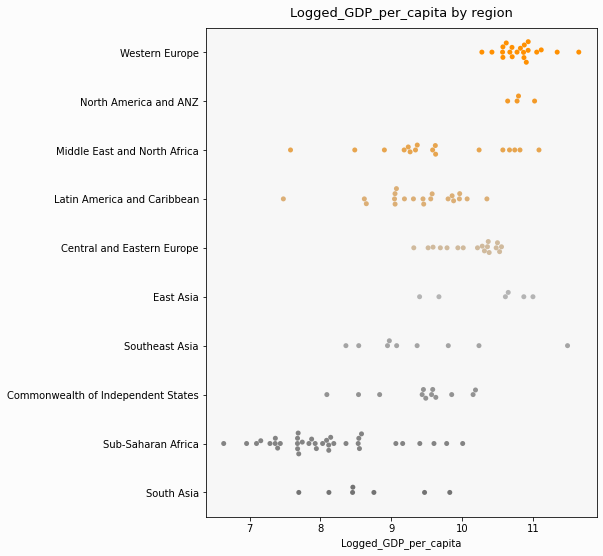

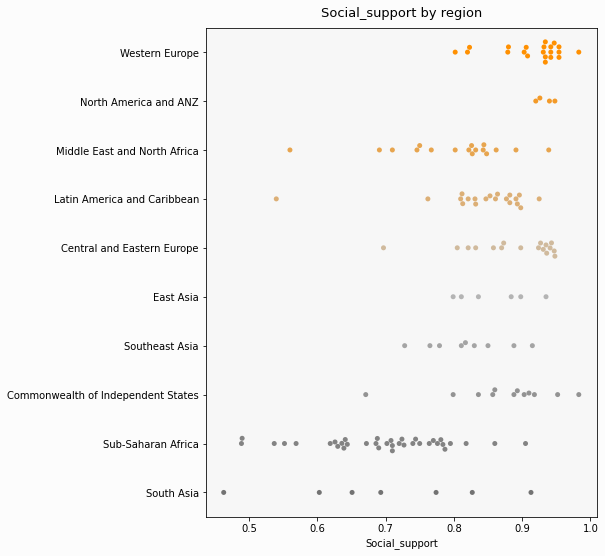

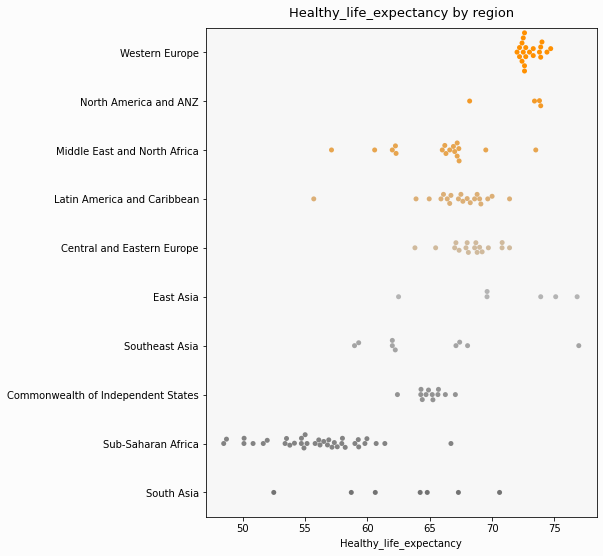

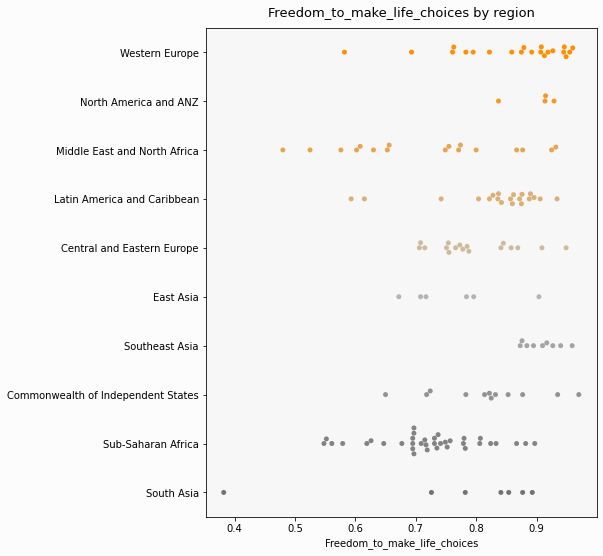

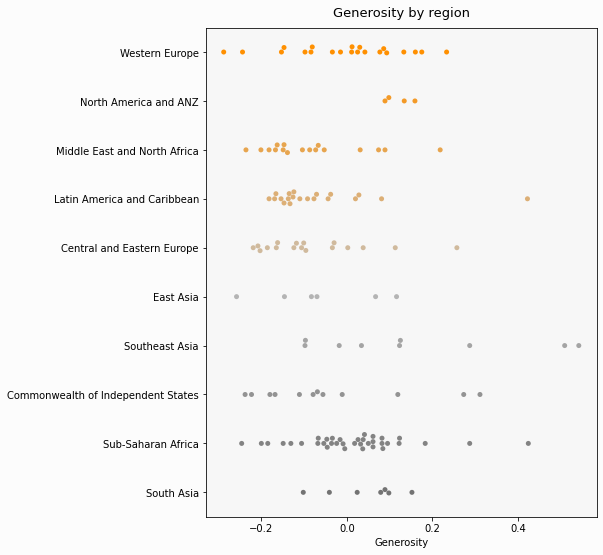

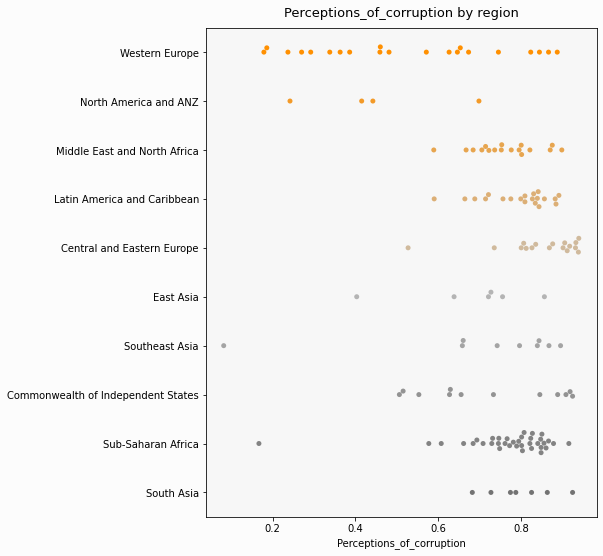

In [130]:
for col in orig_features:
    fig = plt.figure(figsize=(7,9))
    ax = sns.swarmplot(x=col, y='Regional_indicator', palette=category_palette, data=orig_data)
    ax.set_title(f'{col} by region', fontdict={'fontsize':13}, pad=11)
    ax.set_ylabel('');

In [17]:
group = orig_data.groupby('Regional_indicator').mean()
group = pd.DataFrame(group).reset_index()

def total_regplot(x, y, xlim, ylim):
    ax = sns.FacetGrid(orig_data, height=6, xlim=xlim, ylim=ylim).map(plt.scatter, x, 'Ladder_score', color='#FF9001', alpha=0.7)
    ax = sns.regplot(x=x, y='Ladder_score', data=orig_data, color='#FF9001', scatter=False)
    ax.set_title(f'{x} : {y}', fontdict={'fontsize':18}, pad=16);
    
def region_regplot(x, y, xlim, ylim, x_label_pos, y_label_pos):
    ax = sns.FacetGrid(group, height=6, xlim=xlim, ylim=ylim).map(plt.scatter, x, y, color='#FF9001')

    for region in group.Regional_indicator:
        plt.text(x=group[x][group.Regional_indicator==region]+x_label_pos, 
                 y=group[y][group.Regional_indicator==region]+y_label_pos, 
                 s=region,
                 fontdict=dict(color='black', alpha=0.8, size=7.5))

    ax = sns.regplot(x=x, y=y, data=orig_data, color='#FF9001', scatter=False)
    ax.set_title(f'{x} : {y}', fontdict={'fontsize':18}, pad=16);

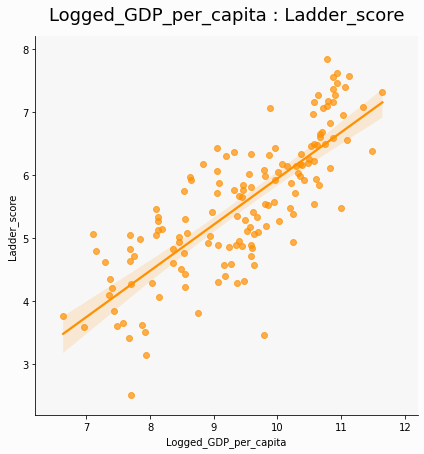

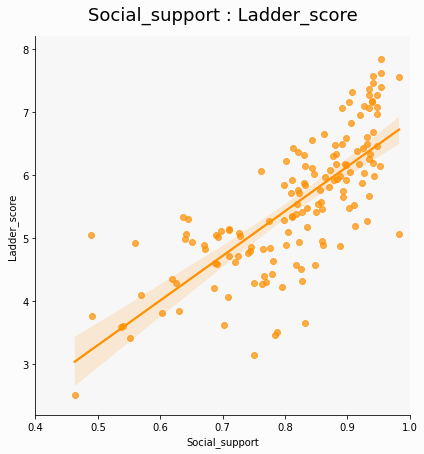

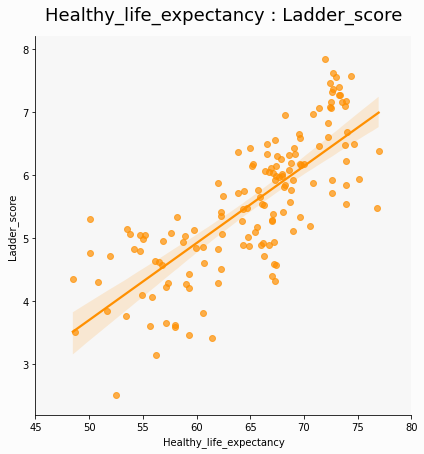

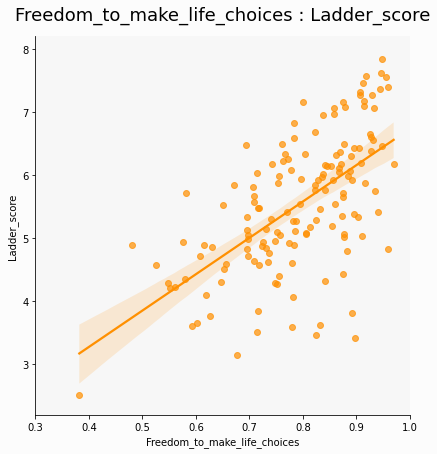

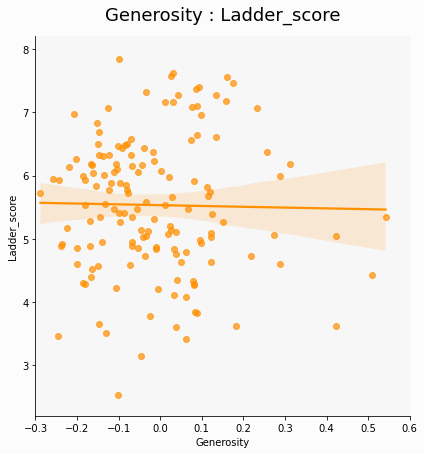

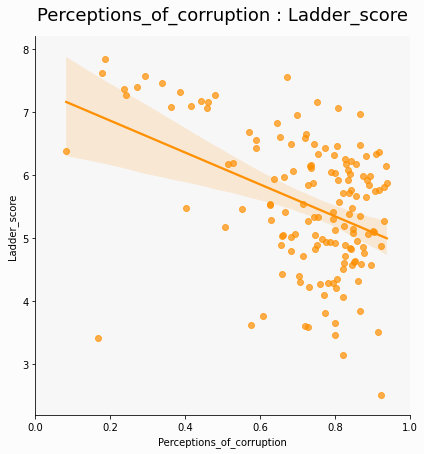

In [18]:
total_lim = ((6.2,12.2), (0.4,1), (45,80), (0.3,1), (-0.3,0.6), (0,1))
region_lim = ((7.6,11.1), (0.66,0.94), (50,75), (0.67,1), (-0.12,0.22), (0.4,0.9))
(2.2,8.2)
(4.1,7.6)
pos = (0.05, 0.005, 0.5, 0.007, 0.005, 0.01)
-0.02

for item, xlim in zip(orig_features, total_lim):
    total_regplot(x=item, y='Ladder_score', xlim=xlim, ylim=(2.2,8.2))

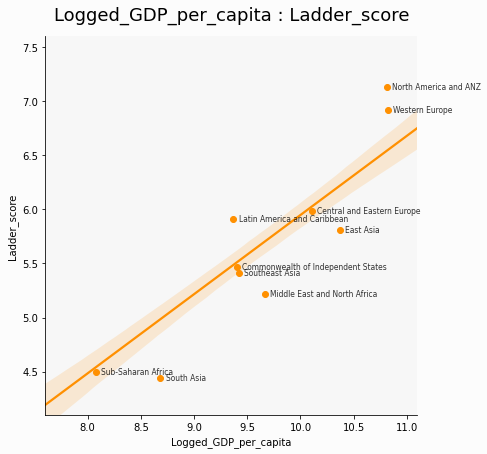

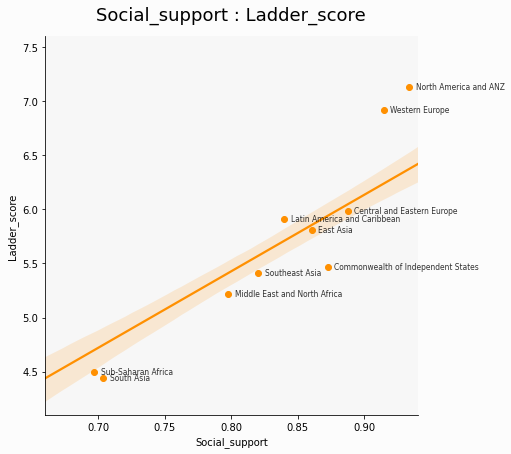

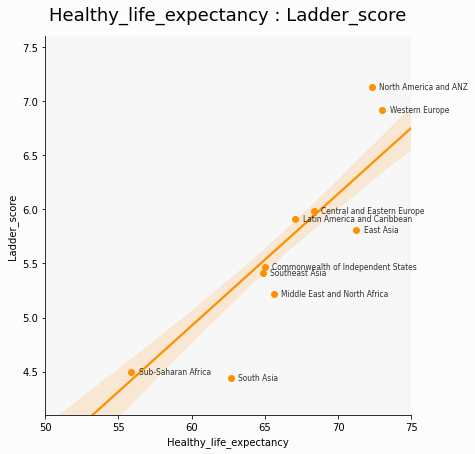

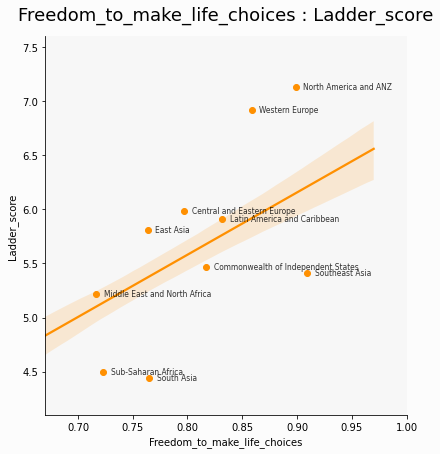

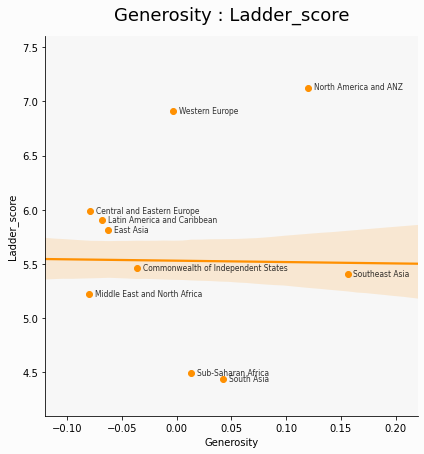

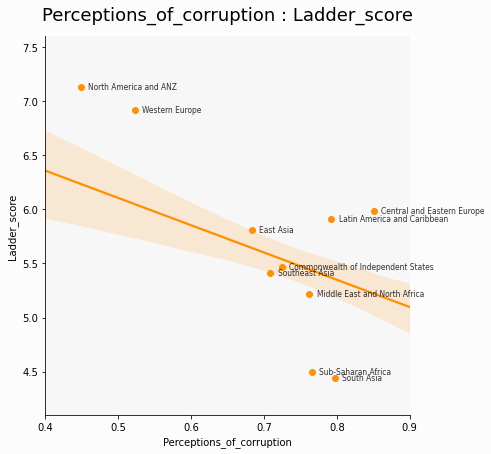

In [19]:
for item, xlim, xpos in zip(orig_features, region_lim, pos):
    region_regplot(x=item, y='Ladder_score', xlim=xlim, ylim=(4.1,7.6), x_label_pos=xpos, y_label_pos=-0.02)

In [20]:
def radar_chart(data, n_yticks=4, y_inf=0, y_sup=1):
    fig = plt.figure(figsize=(3,3))
    ax = plt.subplot(polar='True')

    categories = orig_features

    values = data[orig_features].values[0].tolist()
    values += [values[0]]

    angles = [i / 3.0 * np.pi for i in range(6)]
    angles += [angles[0]]

    plt.polar(angles, values, color='#FF9001', marker='.')
    plt.fill(angles, values, color='#FF9001', alpha=0.3)

    plt.xticks(angles[:-1], categories, size=8)
    ax.set_rlabel_position(0)
    plt.yticks(np.linspace(y_inf, y_sup, num=n_yticks, endpoint=False), color='#4B4B4B', size=0)
    plt.ylim(y_inf,y_sup)
    
    return ax

In [21]:
def highlight_scatterplot(x, y, region, xlim, ylim, ax_x, ax_y):
    temp = orig_data.copy()
    temp.loc[:, region] = (temp.Regional_indicator == region)
    palette=['#C4C4C4','#FF4900']
    sns.scatterplot(x=x, y=y, hue=region, ax=axes[ax_x][ax_y], palette=palette, alpha=0.7, legend=False, data=temp)

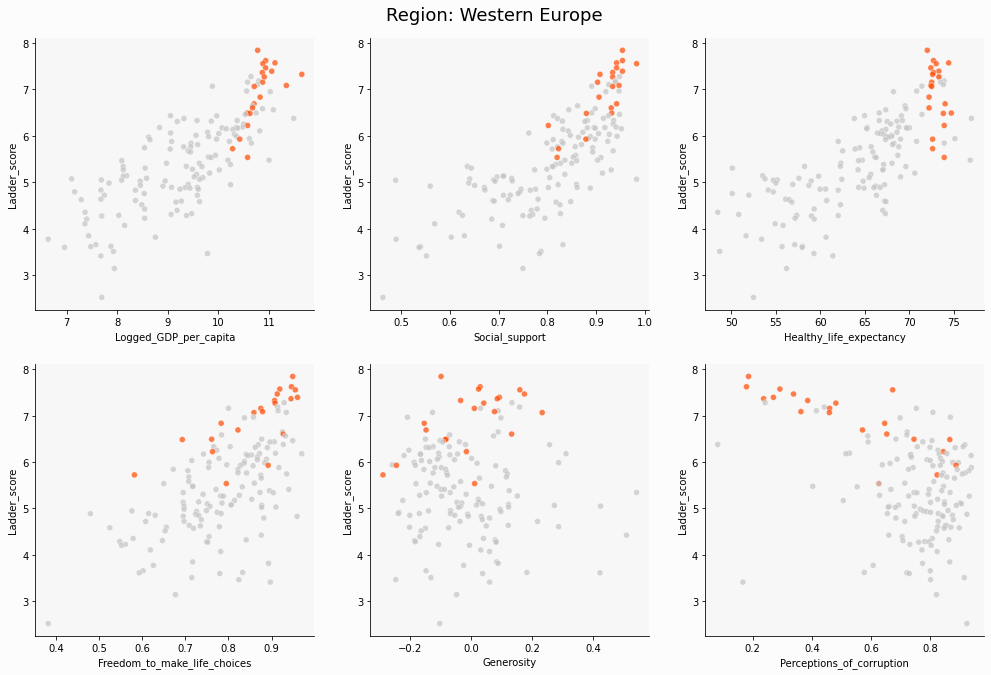

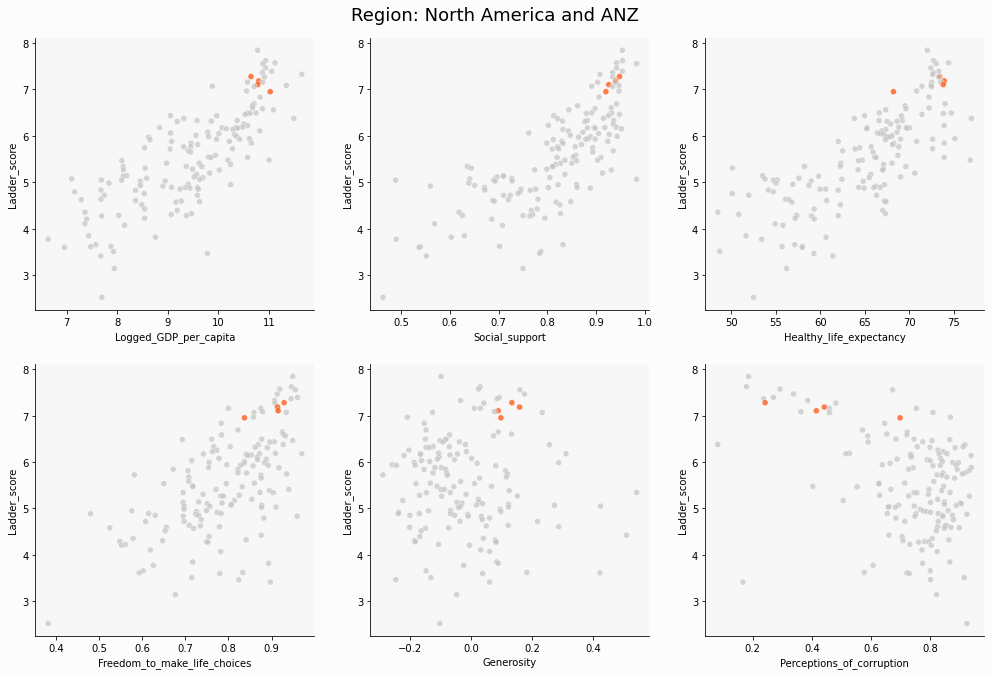

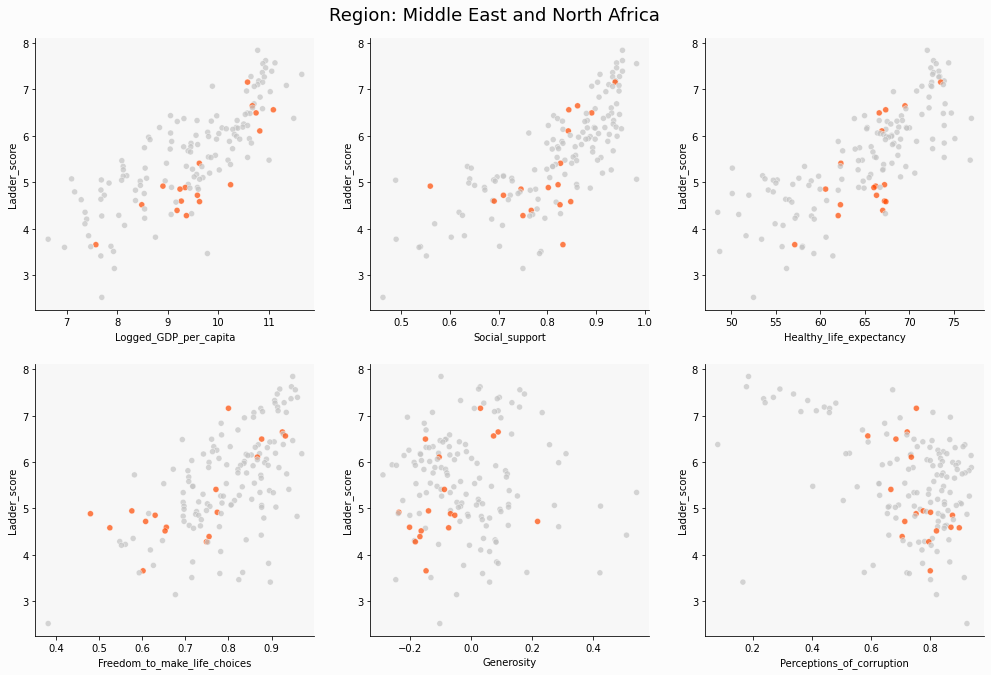

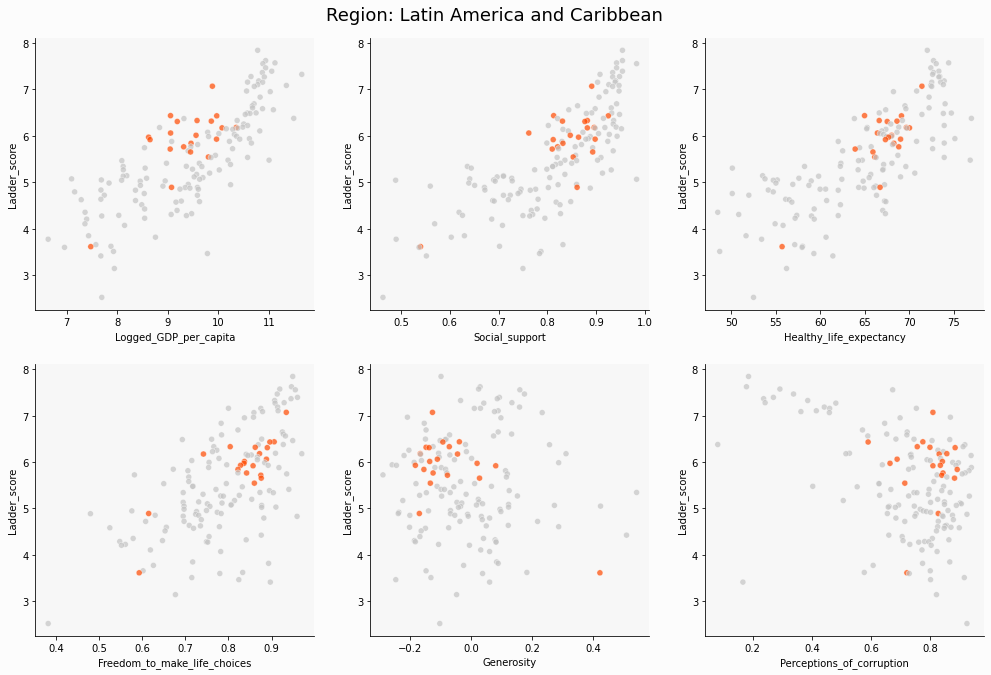

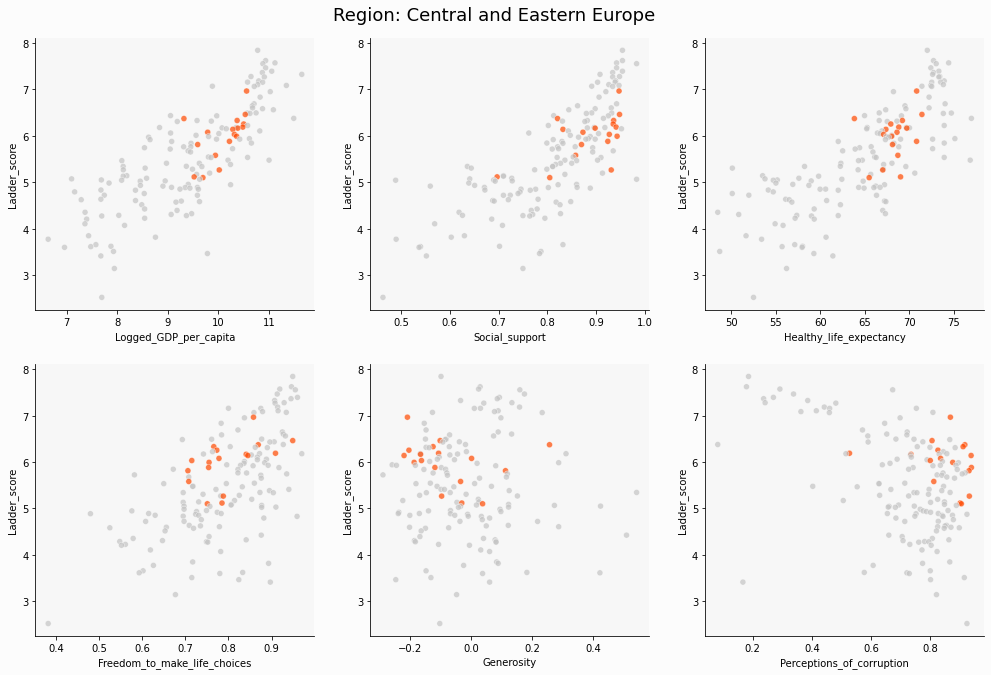

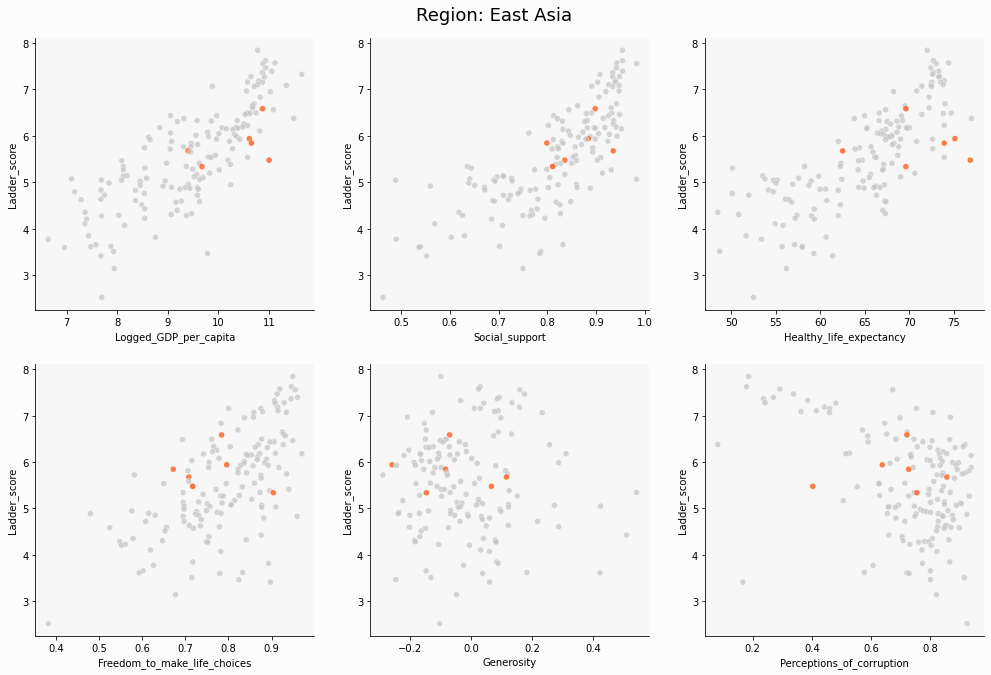

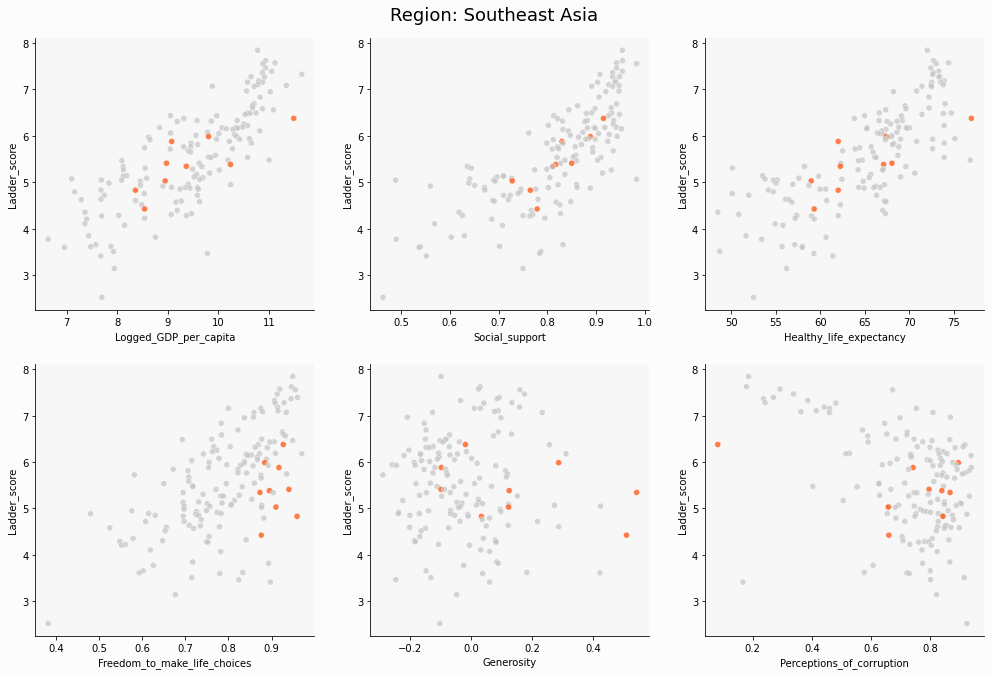

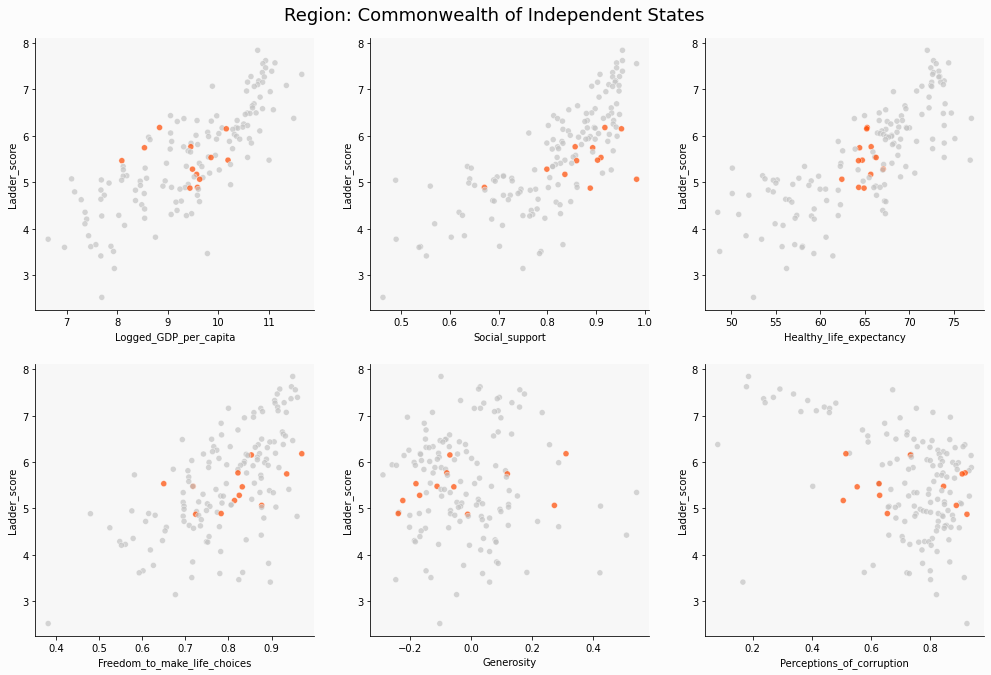

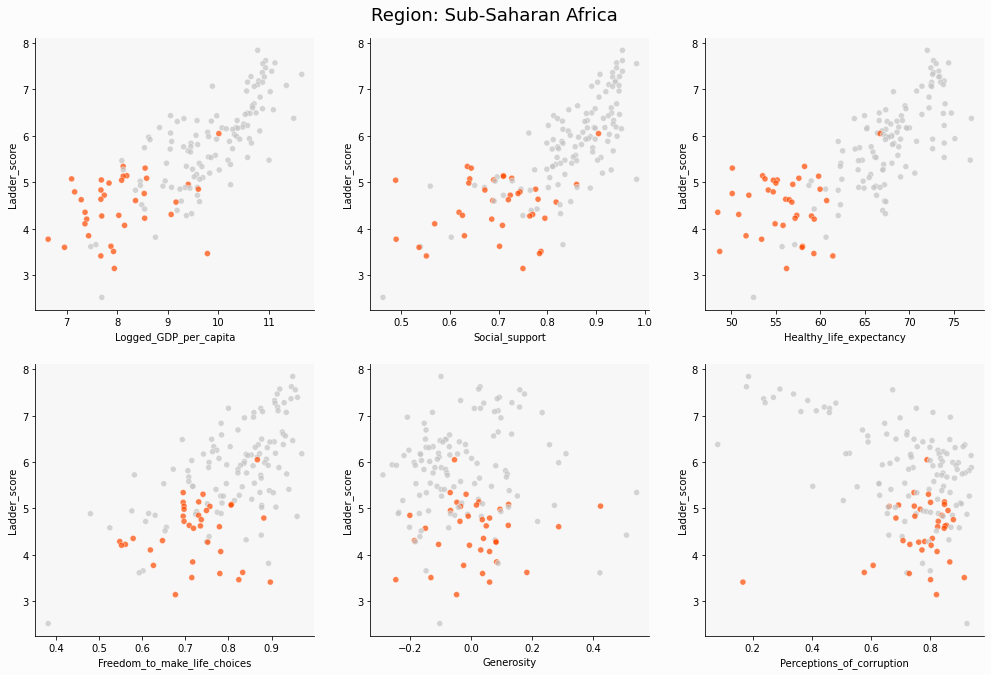

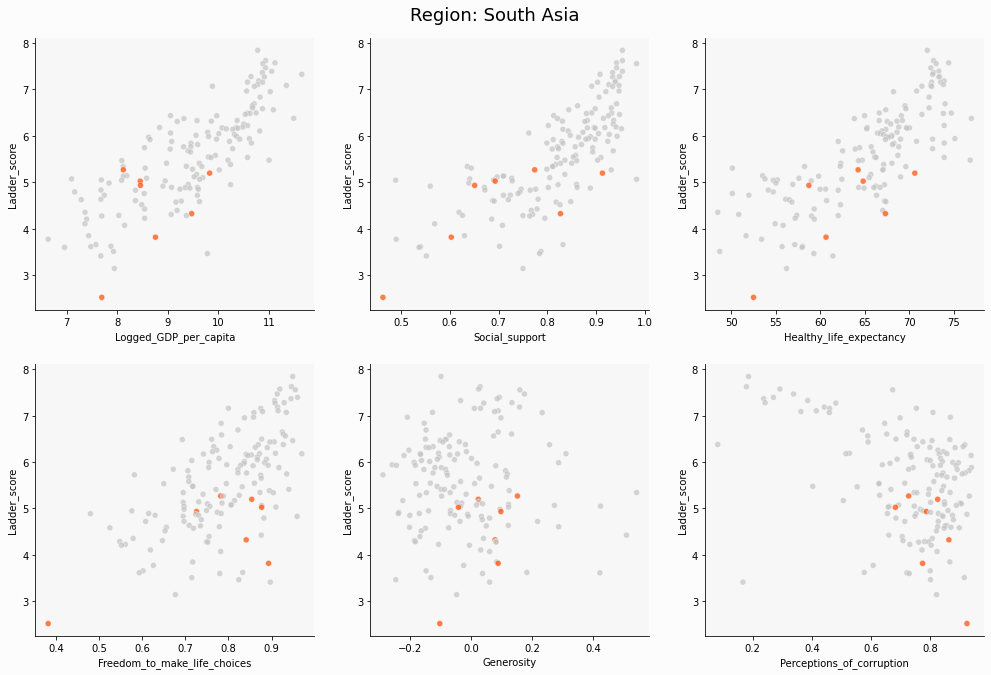

In [22]:
regions = orig_data['Regional_indicator'].unique()

for region in regions:
    fig, axes = plt.subplots(2,3, figsize=(17,11))
    for idx, (feature, xlim) in enumerate(zip(orig_features, total_lim)):
        highlight_scatterplot(x=feature, y='Ladder_score', region=region, xlim=xlim, ylim=(2.2, 8.2), ax_x=idx//3, ax_y=idx%3)
        ax=axes[idx//3][idx%3]
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
   
    fig.suptitle(f'Region: {region}', fontsize=18, y=0.92)

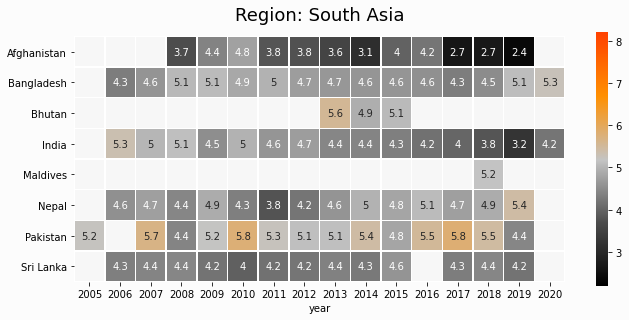

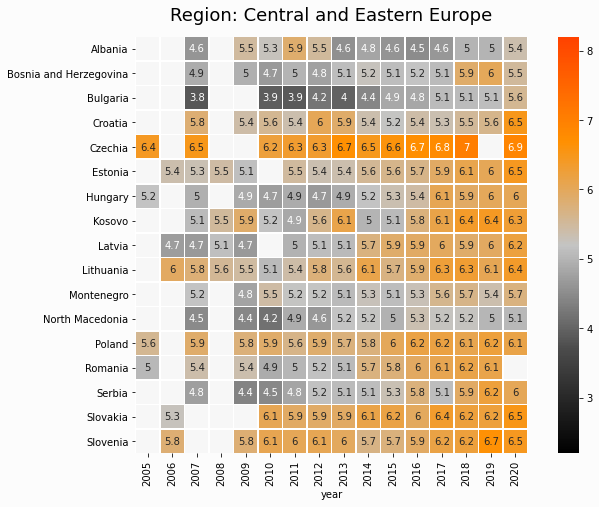

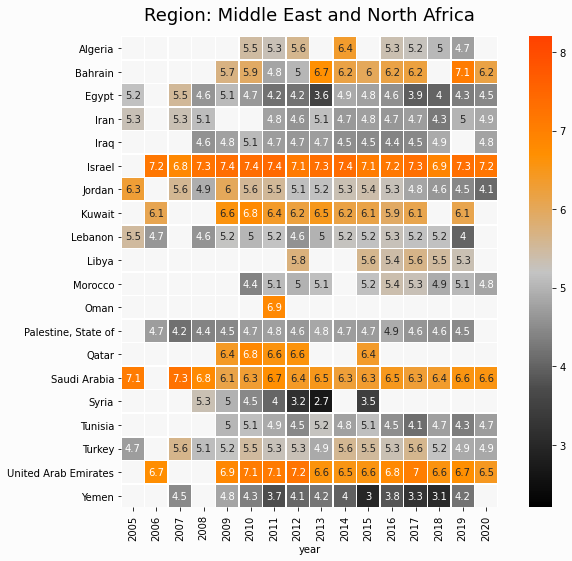

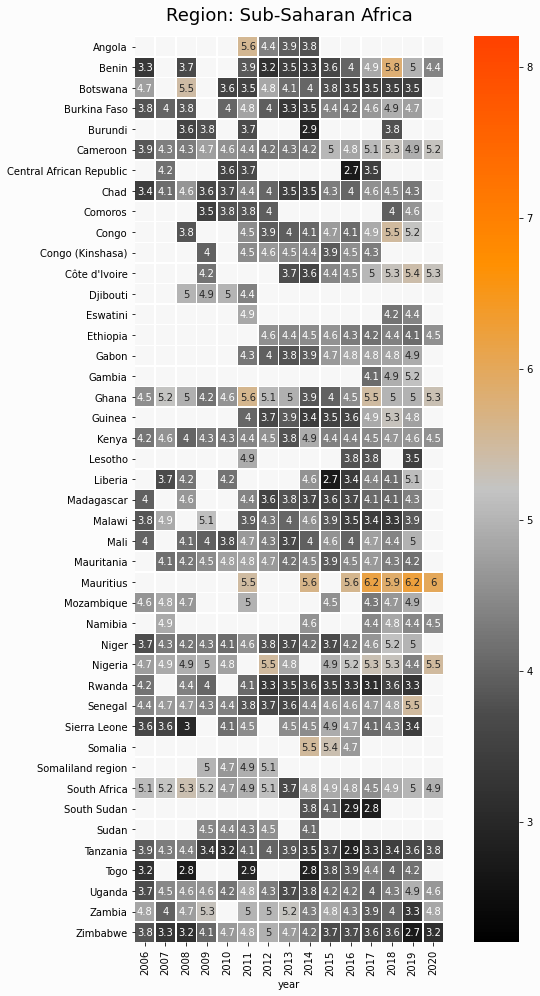

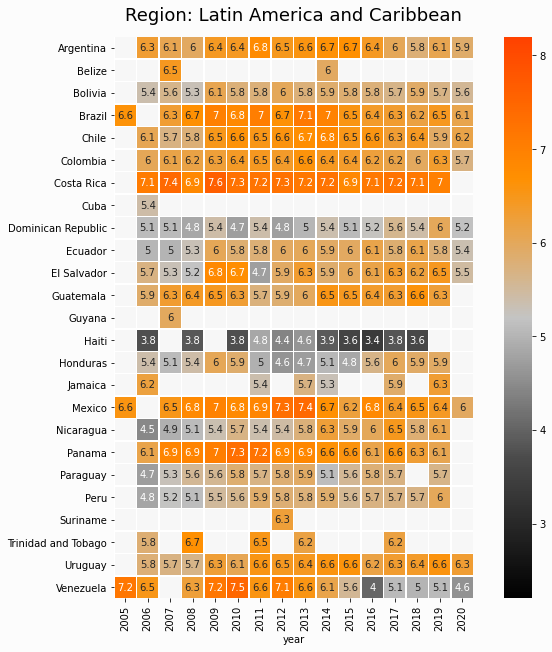

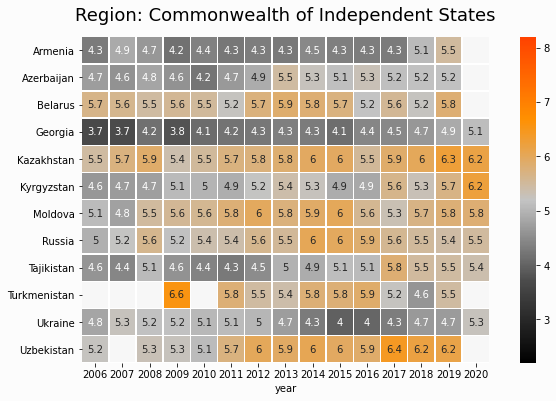

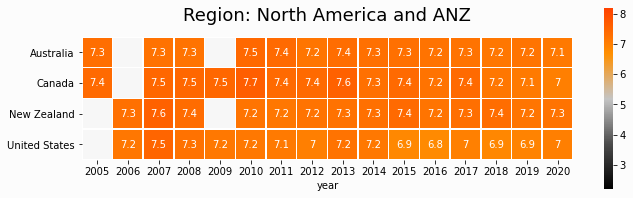

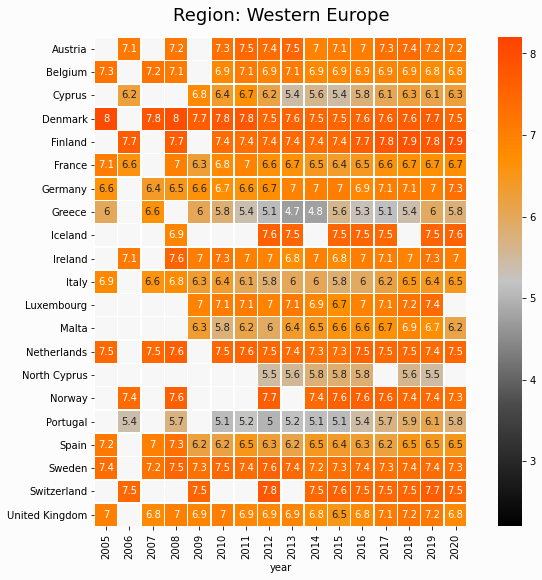

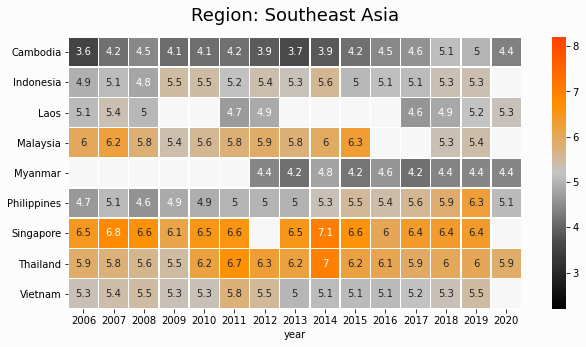

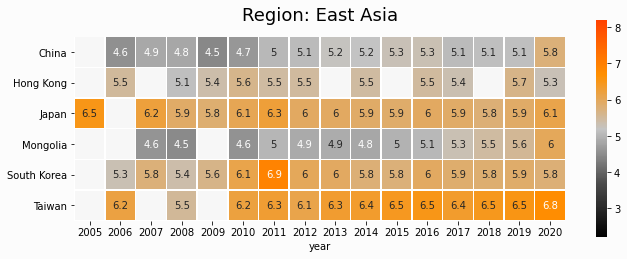

In [23]:
for region in regions:
    ts_region = ts_data[ts_data['Regional_indicator'] == region]
    length = ts_region['Country_name'].nunique()
    pivot = ts_region.pivot('Country_name', 'year', 'Ladder_score')
    
    fig = plt.figure(figsize=(11,2+length/3))
    ax = sns.heatmap(pivot, vmin=2.2, vmax=8.2, cmap=heat_cmap, annot=True, fmt='.2g', linewidth=.5, square=True)
    ax.set_title(f'Region: {region}', fontdict={'fontsize':18}, pad=16)
    ax.set_ylabel('')

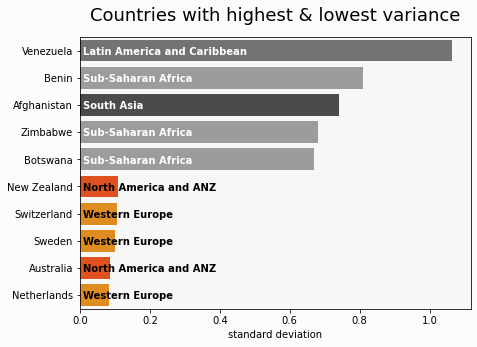

In [24]:
describe = ts_data[['Country_name', 'Ladder_score']].groupby('Country_name').describe()['Ladder_score']
describe = describe[describe['count'] >= 10]
std = describe['std'].dropna().sort_values(ascending=False)
top_bottom_var = pd.concat([std[:5], std[-5:]]).reset_index()
top_bottom_var = top_bottom_var.merge(orig_data[['Country_name', 'Regional_indicator']], how='left')

regions_var = top_bottom_var['Regional_indicator'].reset_index(drop=True)
var_color_list = ['#737373','#9C9C9C','#4B4B4B','#FF4200','#FF9001']
region_var_color = dict(zip(regions_var.unique(), var_color_list))
region_palette2 = list(regions_var.map(lambda x: region_var_color[x]))

fig = plt.figure(figsize=(7,5))
ax = sns.barplot(x='std', y='Country_name', orient='h', palette=region_palette2, data=top_bottom_var)

for i in range(5):
    ax.annotate(regions_var[i], xy=(0.01, i+0.15), weight='bold', color='#FFFFFF')

for i in range(5,10):
    ax.annotate(regions_var[i], xy=(0.01, i+0.15), weight='bold', color='#000000')

ax.set_title(f'Countries with highest & lowest variance', fontdict={'fontsize':18}, pad=16)
ax.set_xlabel('standard deviation')
ax.set_ylabel('');

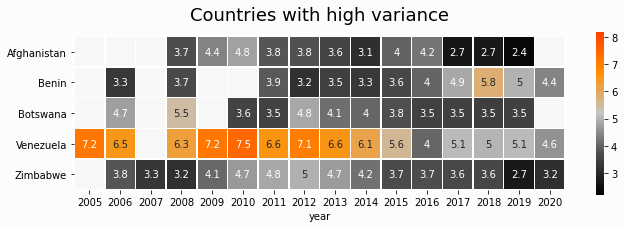

In [25]:
ts_top_var = ts_data[ts_data['Country_name'].isin(std.index[:5])].drop('Regional_indicator', axis=1)
pivot_top_var = ts_top_var.pivot('Country_name', 'year', 'Ladder_score')

fig = plt.figure(figsize=(11,3))
ax = sns.heatmap(data=pivot_top_var, vmin=2.2, vmax=8.2, cmap=heat_cmap, annot=True, 
                      fmt='.2g', linewidth=.5, square=True)
ax.set_title('Countries with high variance', fontdict={'fontsize':18}, pad=16)
ax.set_ylabel('');

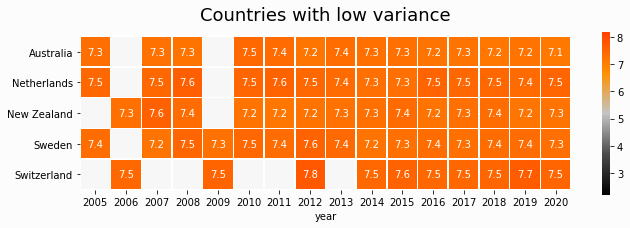

In [26]:
ts_bottom_var = ts_data[ts_data['Country_name'].isin(std.index[-5:])]
pivot_bottom_var = ts_bottom_var.pivot('Country_name', 'year', 'Ladder_score')

fig = plt.figure(figsize=(11,3))
ax = sns.heatmap(data=pivot_bottom_var, vmin=2.2, vmax=8.2, cmap=heat_cmap, annot=True, 
                      fmt='.2g', linewidth=.5, square=True)
ax.set_title('Countries with low variance', fontdict={'fontsize':18}, pad=16)
ax.set_ylabel('');

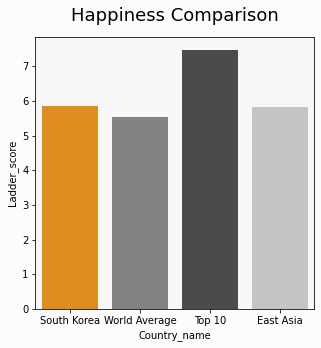

In [74]:
kor_data = orig_data[orig_data['Country_name'] == 'South Korea']

world_average = orig_data.mean()
world_average.loc['Country_name'] = 'World Average'

top_10 = orig_data[:10].mean()
top_10.loc['Country_name'] = 'Top 10'

east_asia = orig_data[orig_data['Regional_indicator'] == 'East Asia'].mean()
east_asia.loc['Country_name'] = 'East Asia'

kor_world_data = pd.concat([kor_data, pd.DataFrame(world_average).T, 
                            pd.DataFrame(top_10).T, pd.DataFrame(east_asia).T]
                          ).drop('Regional_indicator', axis=1)

fig = plt.figure(figsize=(5,5))
kor_palette1 = ['#FF9001','#838383','#4B4B4B','#C4C4C4']
ax = sns.barplot(x='Country_name', y='Ladder_score', palette=kor_palette1, data=kor_world_data)
ax.set_title(f'Happiness Comparison', fontdict={'fontsize':18}, pad=16);

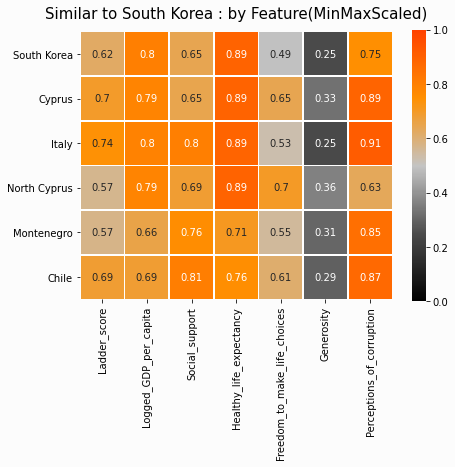

In [46]:
pre_normed = orig_data.drop(['Country_name', 'Regional_indicator'], axis=1)

min_max_scaler = MinMaxScaler()

mm_normed = pd.DataFrame(min_max_scaler.fit_transform(pre_normed), columns=pre_normed.columns)
ls_mm_normed = mm_normed['Ladder_score']
df_mm_normed = pd.concat([orig_data[['Country_name', 'Regional_indicator']], mm_normed], axis=1)

mm_normed.drop('Ladder_score', axis=1, inplace=True)
kor_mm_loc = mm_normed.iloc[kor_loc,:]
distance = []

for i in range(149):
    diff = kor_mm_loc - mm_normed.iloc[i,:]
    score = 0
    for value in diff:
        score += value**2
    distance.append(score)

df_mm_normed['distance'] = distance
kor_mm_similar = df_mm_normed.sort_values(by=['distance']).iloc[:6, :].drop(['Regional_indicator', 'distance'], axis=1).set_index('Country_name')

fig = plt.figure(figsize=(7,5))
ax = sns.heatmap(kor_mm_similar, vmin=0, vmax=1, cmap=heat_cmap, annot=True, fmt='.2g', linewidth=.5, square=True)
ax.set_title(f'Similar to South Korea : by Feature (MinMaxScaled)', fontdict={'fontsize':15}, pad=13)
ax.set_ylabel('');

In [68]:
kor_data_mm = df_mm_normed[df_mm_normed['Country_name'] == 'South Korea']

world_average_mm = df_mm_normed.mean()
world_average_mm.loc['Country_name'] = 'World Average'

top_10_mm = df_mm_normed[:10].mean()
top_10_mm.loc['Country_name'] = 'Top 10'

east_asia_mm = df_mm_normed[df_mm_normed['Regional_indicator'] == 'East Asia'].mean()
east_asia_mm.loc['Country_name'] = 'East Asia'

kor_world_data_mm = pd.concat([kor_data_mm, pd.DataFrame(world_average_mm).T, 
                            pd.DataFrame(top_10_mm).T, pd.DataFrame(east_asia_mm).T]
                          ).drop('Regional_indicator', axis=1)

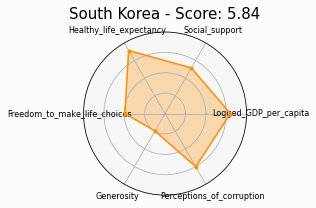

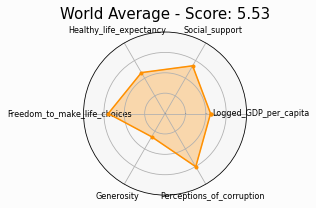

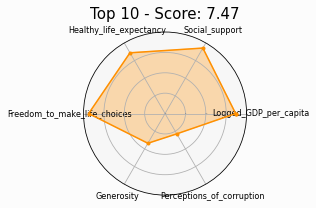

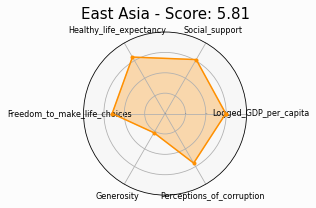

In [80]:
for country in kor_world_data_mm['Country_name'].unique():
    data = kor_world_data_mm[kor_world_data_mm['Country_name'] == country]
    ax = radar_chart(data)
    score = kor_world_data[kor_world_data['Country_name'] == country]['Ladder_score'].values[0]
    ax.set_title(f'{country} - Score: {score:.2f}', 
                 fontdict={'fontsize':15}, pad=13)

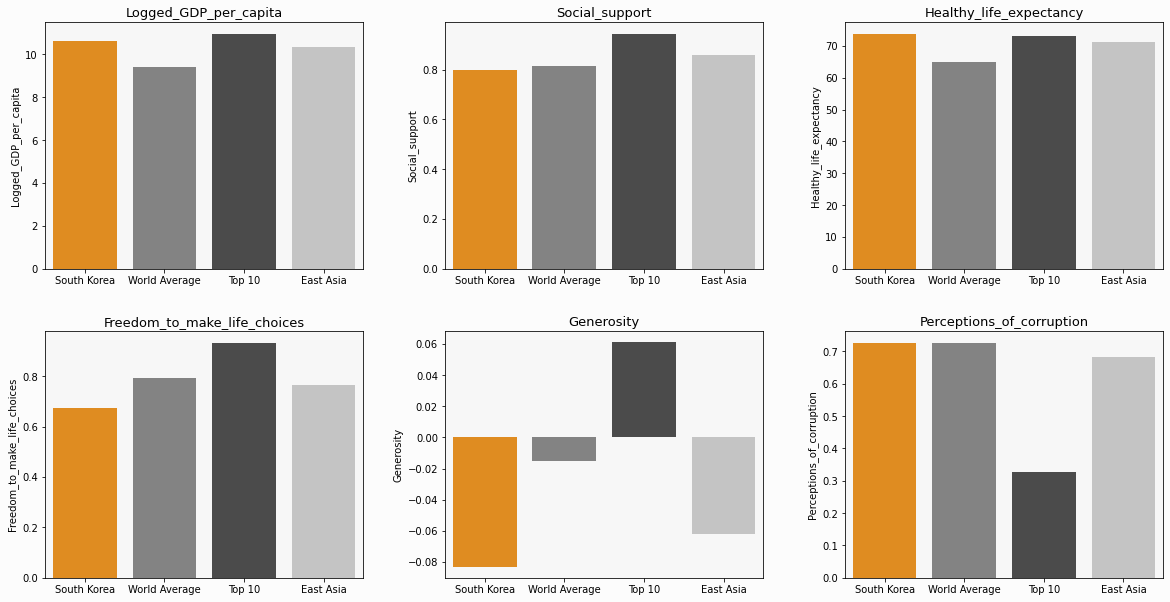

In [28]:
fig, axes = plt.subplots(2,3, figsize=(17,9))
for idx, col in enumerate(orig_features):
    fig.tight_layout(pad=3)
    ax = axes[idx//3][idx%3]
    sns.barplot(x='Country_name', y=col, palette=kor_palette1, ax=ax, data=kor_world_data)
    ax.set_title(f'{col}', fontdict={'fontsize':13}, pad=5)
    ax.set_xlabel('');

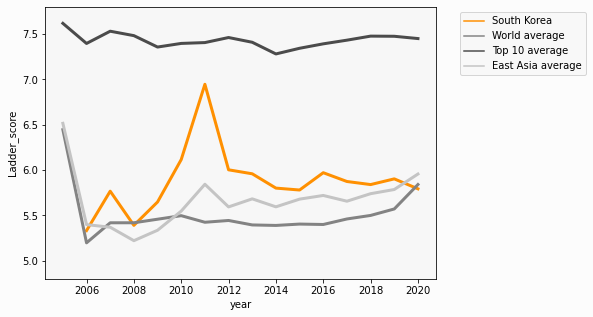

In [29]:
kor_ts_data = ts_data[ts_data['Country_name'] == 'South Korea'].drop('Regional_indicator', axis=1).reset_index(drop=True)

world_average_ts = ts_data.groupby('year').mean().reset_index()
world_average_ts.loc[:,'Country_name']=pd.Series(['World average']*world_average_ts.shape[0])

top_10_ts_list = orig_data['Country_name'][:10]
top_10_ts = ts_data[ts_data['Country_name'].isin(top_10_ts_list)]
top_10_ts = top_10_ts.groupby('year').mean().reset_index()
top_10_ts.loc[:,'Country_name'] = pd.Series(['Top 10 average']*top_10_ts.shape[0])

east_asia_ts = ts_data[ts_data['Regional_indicator'] == 'East Asia']
east_asia_ts = east_asia_ts.groupby('year').mean().reset_index()
east_asia_ts.loc[:,'Country_name'] = pd.Series(['East Asia average']*east_asia_ts.shape[0])

kor_world_ts_data = pd.concat([kor_ts_data, world_average_ts, top_10_ts, east_asia_ts])

fig = plt.figure(figsize=(7,5))

kor_palette2 = ['#FF9001','#838383','#4B4B4B','#C4C4C4']
ax = sns.lineplot(x='year', y='Ladder_score', hue='Country_name', palette=kor_palette2, linewidth=3, data=kor_world_ts_data)
ax.set_ylim(4.8, 7.8)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

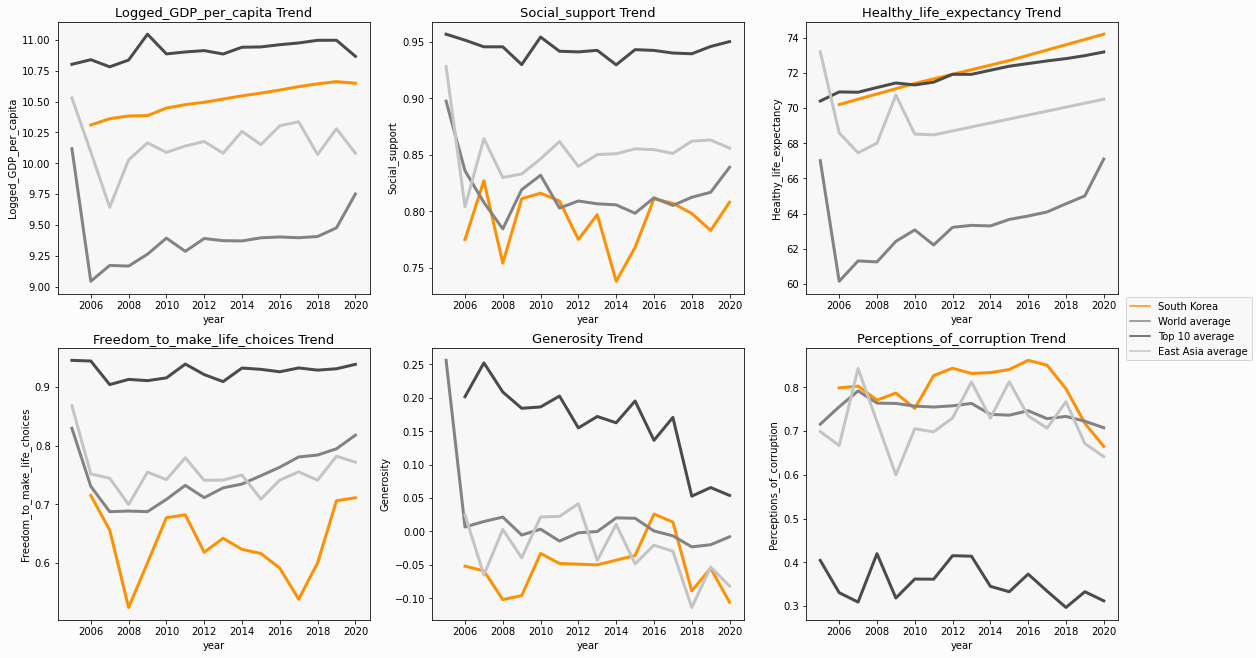

In [32]:
fig, axes = plt.subplots(2,3, figsize=(19,11))
for idx, col in enumerate(orig_features):
    ax = axes[idx//3][idx%3]
    sns.lineplot(x='year', y=col, hue='Country_name', palette=kor_palette2, linewidth=3, ax=ax, data=kor_world_ts_data)
    ax.set_title(f'{col} Trend', fontdict={'fontsize':13}, pad=5)
    ax.get_legend().remove()
handles, labels = axes[1][2].get_legend_handles_labels()
fig.legend(handles, labels, loc='right');

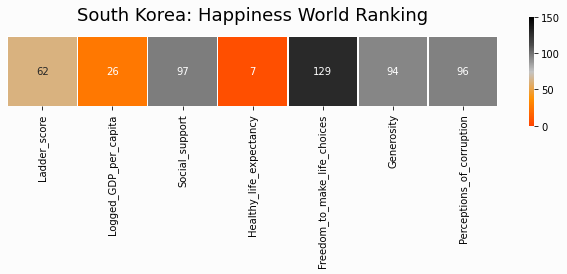

In [131]:
rank_data = orig_data.copy()
for col in orig_score_and_features:
    rank_data[col] = rank_data[col].rank(method='min', ascending=False)
kor_rank = rank_data[rank_data['Country_name'] == 'South Korea'].drop('Regional_indicator', axis=1).set_index('Country_name')

norm = mpl.colors.Normalize(-1,1)
colors = [[norm(-1.0), '#FF4200'], 
          [norm(-0.5), '#FF9001'], 
          [norm(0), '#C4C4C4'], 
          [norm(0.5), '#4B4B4B'], 
          [norm(1.0), '#000000']]
heat_cmap_r = mpl.colors.LinearSegmentedColormap.from_list("", colors)

fig = plt.figure(figsize=(11,2))
ax = sns.heatmap(kor_rank, vmin=0, vmax=150, cmap=heat_cmap_r, annot=True, 
                 fmt='g', linewidth=.5, square=True)
ax.set_title(f'South Korea: Happiness World Ranking', fontdict={'fontsize':18}, pad=16)
ax.yaxis.set_ticks([])
ax.set_yticklabels('')
ax.set_ylabel('');

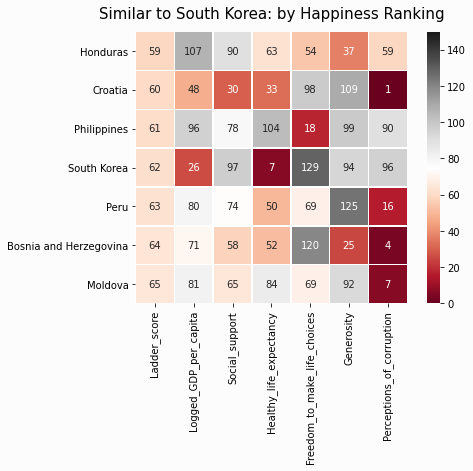

In [133]:
kor_loc = rank_data.index[rank_data['Country_name'] == 'South Korea'][0]
kor_neighborhood = rank_data.iloc[kor_loc-3:kor_loc+4,:].set_index('Country_name')

fig = plt.figure(figsize=(7,5))
ax = sns.heatmap(kor_neighborhood[orig_score_and_features], vmin=0, vmax=150, cmap='RdGy', annot=True, 
                 fmt='g', linewidth=.5, square=True)
ax.set_title(f'Similar to South Korea: by Happiness Ranking', fontdict={'fontsize':15}, pad=13)
ax.set_ylabel('');

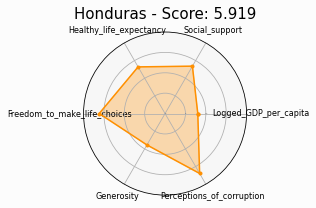

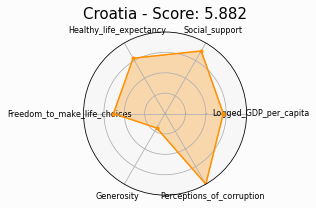

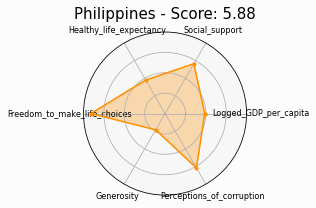

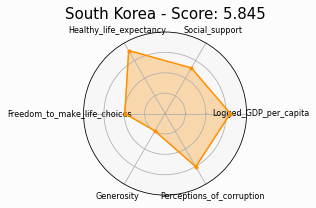

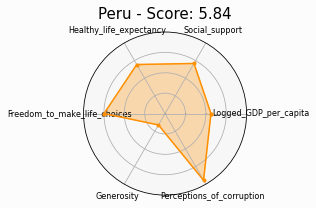

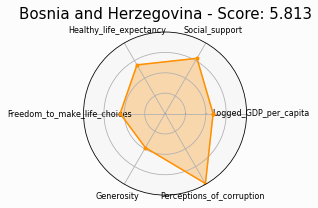

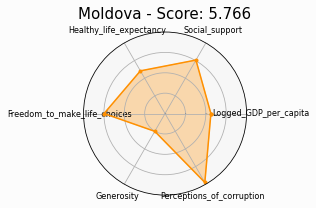

In [62]:
for country in kor_neighborhood.index:
    data = df_mm_normed[df_mm_normed['Country_name'] == country]
    ax = radar_chart(data)
    score = orig_data[orig_data['Country_name'] == country]['Ladder_score'].values[0]
    ax.set_title(f'{country} - Score: {score}', 
                 fontdict={'fontsize':15}, pad=13)